In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import scipy as sp
import string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import model libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks

In [3]:
# Read in amazon reviews and add source
df_amazon = pd.read_csv("data\sentiment labelled sentences\amazon_cells_labelled.txt", delimiter='\t', header=None, names=["text","sentiment"])
df_amazon['source'] = 'amazon'
df_amazon

,text,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
...,...,...,...
995,The screen does get smudged easily because it ...,0,amazon
996,What a piece of junk.. I lose more calls on th...,0,amazon
997,Item Does Not Match Picture.,0,amazon
998,The only thing that disappoint me is the infra...,0,amazon


In [4]:
# Read in imdb reviews, ensure lines are separated properly and add source
imdb = open("data\sentiment labelled sentences\imdb_labelled.txt").read()

i_labels, i_texts = [], []
for i, line in enumerate(imdb.split('\n')):
    content = line.split('\t')
    if len(content) > 1:
        i_texts.append(content[0])
        i_labels.append(content[1])
        
df_imdb = pd.DataFrame()
df_imdb['text'] = i_texts
df_imdb['sentiment'] = i_labels
df_imdb['source'] = 'imdb'
df_imdb

,text,sentiment,source
0,"A very, very, very slow-moving, aimless movie ...",0,imdb
1,Not sure who was more lost - the flat characte...,0,imdb
2,Attempting artiness with black & white and cle...,0,imdb
3,Very little music or anything to speak of.,0,imdb
4,The best scene in the movie was when Gerardo i...,1,imdb
...,...,...,...
995,I just got bored watching Jessice Lange take h...,0,imdb
996,"Unfortunately, any virtue in this film's produ...",0,imdb
997,"In a word, it is embarrassing.",0,imdb
998,Exceptionally bad!,0,imdb


In [5]:
# Read in yelp reviews and add source
df_yelp = pd.read_csv("data\sentiment labelled sentences\yelp_labelled.txt", delimiter='\t', header=None, names=["text","sentiment"])
df_yelp['source'] = 'yelp'
df_yelp

,text,sentiment,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
...,...,...,...
995,I think food should have flavor and texture an...,0,yelp
996,Appetite instantly gone.,0,yelp
997,Overall I was not impressed and would not go b...,0,yelp
998,"The whole experience was underwhelming, and I ...",0,yelp


In [6]:
# Concatenate the sets
df = pd.concat([df_amazon, df_imdb, df_yelp], ignore_index=True)
df['sentiment'] = pd.to_numeric(df['sentiment'])
df

,text,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
...,...,...,...
2995,I think food should have flavor and texture an...,0,yelp
2996,Appetite instantly gone.,0,yelp
2997,Overall I was not impressed and would not go b...,0,yelp
2998,"The whole experience was underwhelming, and I ...",0,yelp


In [7]:
# Exploratory analysis
df_analysis = df.copy(deep=True)
df_analysis['chars'] = df_analysis.text.apply(len)
df_analysis['words'] = df_analysis.text.apply(lambda x: len(x.split()))
df_analysis['avg_wlen'] = df_analysis['chars'] / df_analysis['words']
df_analysis['puncs'] = df_analysis.text.apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df_analysis['uppers'] = df_analysis.text.apply(lambda x: len([word for word in x.split() if word.isupper()]))
df_analysis['titles'] = df_analysis.text.apply(lambda x: len([word for word in x.split() if word.istitle()]))
df_analysis.head()

,text,sentiment,source,chars,words,avg_wlen,puncs,uppers,titles
0,So there is no way for me to plug it in here i...,0,amazon,82,21,3.904762,1,2,2
1,"Good case, Excellent value.",1,amazon,27,4,6.750000,2,0,2
2,Great for the jawbone.,1,amazon,22,4,5.500000,1,0,1
3,Tied to charger for conversations lasting more...,0,amazon,79,11,7.181818,3,1,1
4,The mic is great.,1,amazon,17,4,4.250000,1,0,1


In [8]:
display(df_analysis.groupby(['source', 'sentiment']).describe().loc[:,(slice(None),['mean', 'std'])].reset_index())
display(df_analysis.groupby(['source', 'sentiment']).describe().loc[:,(slice(None),['min', 'max'])].reset_index())

source sentiment   chars              words             avg_wlen            \
                       mean        std    mean        std      mean       std   
0  amazon         0  56.824  34.022464  10.578   6.578028  5.653474  1.262250   
1  amazon         1  53.628  35.234764   9.914   6.785772  5.670933  1.113802   
2    imdb         0  77.104  50.901504  13.580   9.037863  5.814498  0.941015   
3    imdb         1  87.466  60.831157  15.128  10.102859  5.826946  0.992992   
4    yelp         0  60.750  34.224935  11.498   6.611916  5.401276  0.896919   
5    yelp         1  55.882  30.228390  10.290   5.831459  5.606414  0.951573   

   puncs           uppers           titles            
    mean       std   mean       std   mean       std  
0  2.002  1.509488  0.558  1.223777  1.242  0.888265  
1  1.842  1.296301  0.410  0.637741  1.304  0.892848  
2  2.494  1.954893  0.362  0.745700  1.434  1.420450  
3  2.650  2.282525  0.400  0.710641  1.800  1.730314  
4  2.000  1.424098  0.500  0.965331  1.326  0.932450  
5  1.930  1.658494  0.300  0.553727  1.342  0.889167

source sentiment chars        words        avg_wlen       puncs        \
                      min    max   min   max       min   max   min   max   
0  amazon         0  11.0  149.0   1.0  30.0  3.857143  14.0   0.0  11.0   
1  amazon         1  11.0  148.0   1.0  30.0  3.166667  13.0   0.0   9.0   
2    imdb         0   8.0  321.0   1.0  56.0  4.181818  11.5   1.0  14.0   
3    imdb         1   7.0  479.0   1.0  71.0  3.200000  12.0   0.0  18.0   
4    yelp         0  11.0  149.0   2.0  32.0  3.666667  12.5   0.0  11.0   
5    yelp         1  11.0  148.0   1.0  32.0  3.666667  11.0   0.0  19.0   

  uppers       titles        
     min   max    min   max  
0    0.0  15.0    0.0   6.0  
1    0.0   3.0    0.0   8.0  
2    0.0   6.0    0.0  22.0  
3    0.0   4.0    0.0  13.0  
4    0.0  13.0    0.0   7.0  
5    0.0   3.0    0.0   7.0

In [9]:
# Cleanup special characters
spec_char = ["!",'"',"#","%","&","(",")",
             "*","+",",","-",".","/",":",";","<",
             "=",">","?","@","[","\\","]","^","_",
             "`","{","|","}","~","–"]

for char in spec_char:
    df['text'] = df['text'].str.replace(char, ' ',regex=True)

# Convert capital to lowercase
df['text'] = df['text'].str.lower()
df

,text,sentiment,source
0,so there is no way for me to plug it in here i...,0,amazon
1,good case excellent value,1,amazon
2,great for the jawbone,1,amazon
3,tied to charger for conversations lasting more...,0,amazon
4,the mic is great,1,amazon
...,...,...,...
2995,i think food should have flavor and texture an...,0,yelp
2996,appetite instantly gone,0,yelp
2997,overall i was not impressed and would not go b...,0,yelp
2998,the whole experience was underwhelming and i ...,0,yelp


In [10]:
# Save prepared set to new file
df.to_csv("data\sentiment labelled sentences\sentiment_clean.csv")

In [11]:
# Shuffling the data before splitting into test/train
df_shuf = df.sample(frac=1).reset_index(drop=True)
df_shuf

,text,sentiment,source
0,i guess it was supposed to be clever twist th...,0,imdb
1,the service was a bit lacking,0,yelp
2,how stupid is that,0,amazon
3,after arguing with verizon regarding the dropp...,0,amazon
4,took an hour to get our food only 4 tables in ...,0,yelp
...,...,...,...
2995,i might have gotten a defect but i would not ...,0,amazon
2996,comfortable nice range good battery life,1,amazon
2997,lange had become a great actress,1,imdb
2998,the casting is also horrible cause all you se...,0,imdb


In [12]:
# Create train/test split
split = round(len(df_shuf)*0.75)
train_text = df_shuf['text'][:split]
train_sentiment = df_shuf['sentiment'][:split]
test_text = df_shuf['text'][split:]
test_sentiment = df_shuf['sentiment'][split:]

In [13]:
# Convert to string after tokenizing
training_text = []
training_sentiment = []
testing_text = []
testing_sentiment = []
for row in train_text:
    training_text.append(str(row))
for row in train_sentiment:
    training_sentiment.append(row)
for row in test_text:
    testing_text.append(str(row))
for row in test_sentiment:
    testing_sentiment.append(row)

In [14]:
# Training at 50000 words
vocab_size = 50000
# 16 dimensions of embedding
embedding_dim = 16
# Max length of 120 words per review
max_length = 120
# Truncating after 120 
trunc_type = 'post'
oov_tok = '<OOV>'
# Padding after 120
padding_type = 'post'

In [16]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Fitting tokenizer
tokenizer.fit_on_texts(training_text)
# Generate word index
word_index = tokenizer.word_index

In [19]:
# Run tokenizer
sequences = tokenizer.texts_to_sequences(training_text)
# Set padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_text)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [20]:
# Creating model
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
        ])

In [21]:
# Compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           800000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 6)                 66        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 800,243
Trainable params: 800,243
Non-trainable params: 0
__________________________________________________

In [23]:
# Convert lists to arrays
training_final = np.array(training_sentiment)
testing_final = np.array(testing_sentiment)

In [24]:
# Running the model for 25 epochs
model1 = model.fit(padded, training_final, epochs=25, validation_data=(testing_padded,
testing_final))

Epoch 1/25
71/71 [==============================] - 1s 5ms/step - loss: 0.9874 - accuracy: 0.4902 - val_loss: 0.7096 - val_accuracy: 0.5293
Epoch 2/25
71/71 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.5333 - val_loss: 0.6896 - val_accuracy: 0.5080
Epoch 3/25
71/71 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.6093 - val_loss: 0.6833 - val_accuracy: 0.5893
Epoch 4/25
71/71 [==============================] - 0s 4ms/step - loss: 0.6724 - accuracy: 0.6636 - val_loss: 0.6778 - val_accuracy: 0.6000
Epoch 5/25
71/71 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.7422 - val_loss: 0.6690 - val_accuracy: 0.6213
Epoch 6/25
71/71 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.7569 - val_loss: 0.6506 - val_accuracy: 0.7707
Epoch 7/25
71/71 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.8222 - val_loss: 0.6348 - val_accuracy: 0.6280
Epoch 8/25
71/71 [==

In [25]:
# Set early stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(monitor ="val_loss", 
                                     mode ="min", patience = 5, 
                                     restore_best_weights = True)

# Re-run model
model2 = model.fit(padded, training_final, epochs=25, validation_data=(testing_padded,
                                                                       testing_final),
                                                                       callbacks = [early_stop])

Epoch 1/25
71/71 [==============================] - 0s 4ms/step - loss: 0.0537 - accuracy: 0.9920 - val_loss: 1.0719 - val_accuracy: 0.8200
Epoch 2/25
71/71 [==============================] - 0s 4ms/step - loss: 0.0505 - accuracy: 0.9924 - val_loss: 1.1473 - val_accuracy: 0.8067
Epoch 3/25
71/71 [==============================] - 0s 4ms/step - loss: 0.0500 - accuracy: 0.9924 - val_loss: 1.1343 - val_accuracy: 0.8133
Epoch 4/25
71/71 [==============================] - 0s 4ms/step - loss: 0.0485 - accuracy: 0.9951 - val_loss: 1.2221 - val_accuracy: 0.8067
Epoch 5/25
71/71 [==============================] - 0s 5ms/step - loss: 0.0471 - accuracy: 0.9933 - val_loss: 1.1504 - val_accuracy: 0.8187
Epoch 6/25
71/71 [==============================] - 0s 4ms/step - loss: 0.0450 - accuracy: 0.9960 - val_loss: 1.1428 - val_accuracy: 0.8187


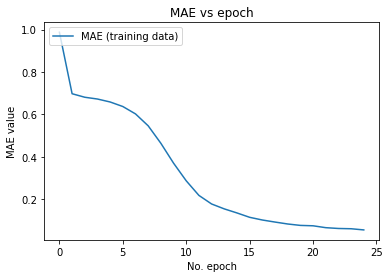

In [26]:
# PLot MAE vs. epoch
plt.plot(model1.history['loss'], label='MAE (training data)')
plt.title('MAE vs epoch')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

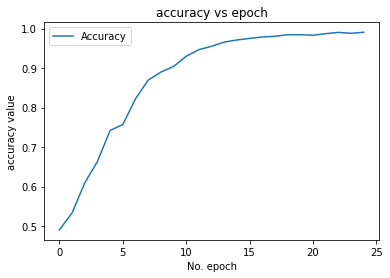

In [27]:
# Plot accuracy vs. epoch
plt.plot(model1.history['accuracy'], label='Accuracy')
plt.title('accuracy vs epoch')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

<Figure size 432x288 with 0 Axes>

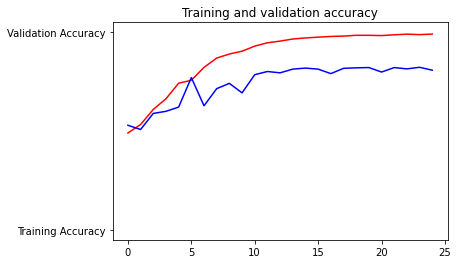

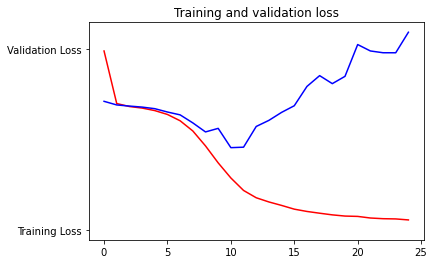

<Figure size 432x288 with 0 Axes>

In [28]:
# Plot model accuracy
acc = model1.history['accuracy']
val_acc = model1.history['val_accuracy']
loss = model1.history['loss']
val_loss = model1.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()